# First steps with COSIPY

This is the first tutorial to get you started with using COSIPY. In it we will go through how to setup a simulation and run it on a single gridpoint.

First we have to import some useful modules

In [1]:
# Have to change the cwd for the ipython session, otherwise COSIPY
# will look for things in the wrong places.
import os
# This is not really a good method, if cell is re run we end up in the
# wrong directory.
os.chdir('./../')

In [125]:
from cosipy.cpkernel.cosipy_core import cosipy_core
from cosipy.cpkernel.io import IOClass
# We need io for changing config parameters/constants.
import cosipy.cpkernel.io as io
import numpy as np
from matplotlib import pyplot as plt

In [6]:
# Have to tell matplotlib to plot inline
%matplotlib inline

# Create input/output files
First we have to creat input/ouput files for the simulation. This is handled by the `IOClass` of COSIPY which creates an xarray dataset containing information about the spatial and temporal coordinate, the data varialbes and the attributes used in the simulation. 

Before we initialize these files, it is interesting to have a look at the varialbes and constants used by the `io` module:

In [31]:
# Initialize the IOClass
IO = IOClass()

In [24]:
# Print the variables in io and their values.
for variable in dir(io):
    if not variable.startswith('__'):
        print(variable, ':', getattr(io, variable))

IOClass : <class 'cosipy.cpkernel.io.IOClass'>
WRF : False
WRF_X_CSPY : False
aging_factor_roughness : 0.0026
air_density : 1.1
albedo_firn : 0.55
albedo_fresh_snow : 0.85
albedo_ice : 0.3
albedo_method : Oerlemans98
albedo_mod_snow_aging : 22
albedo_mod_snow_depth : 3
center_snow_transfer_function : 1.0
compression_level : 2
configparser : <module 'configparser' from '/home/erik/miniconda3/envs/cosipy/lib/python3.6/configparser.py'>
const_init_temp : 0.1
constant_density : 300.0
correctRadiation : <function correctRadiation at 0x7f6ea76adbf8>
data_path : ./data/
densification_method : Boone
density_threshold_merging : 5
dt : 3600
easting : lon
eval_method : rmse
first_layer_height : 0.01
force_use_N : False
force_use_TP : False
full_field : False
ice_density : 917.0
initial_bottom_density_snowpack : 600.0
initial_glacier_height : 40.0
initial_glacier_layer_heights : 0.5
initial_snow_layer_heights : 0.1
initial_snowheight_constant : 0.2
initial_top_density_snowpack : 300.0
input_netcdf

These are loaded from the files `config.py` and `constants.py` located in the root directory of cosipy. We can change any of these variables to customise our simulation. This can by changing the value of a variable in the previously mentioned files, however for this to take affect we have to reload the `io` moduel. 

A much simpler way is to change it directly in this session. For instance we can change the variable `time_end` to adjust the temporal extent of our simulation by running

In [136]:
io.time_end = '2009-01-08T00:00'

After we've changed the value of a varaible of the `io` module we can initialise the data files for our run:

In [137]:
# Create files for the data, results and restart.
DATA = IO.create_data_file()
RESULTS = IO.create_result_file()
RESTART = IO.create_restart_file()


 Maximum available time interval from 2009-01-01T00:00 until 2009-01-31T23:00. Time steps: 744 


--------------------------------------------------------------
	 Integration from 2009-01-01T06:00 to 2009-01-08T00:00
--------------------------------------------------------------

--------------------------------------------------------------
Checking input data .... 

Temperature data (T2) ... ok 
Please check the input data, its seems they are out of range T2 MAX: 261.54 MIN: 238.74 

Relative humidity data (RH2) ... ok 
Shortwave data (G) ... ok 
Wind velocity data (U2) ... ok 
Precipitation data (RRR) ... ok 
Cloud cover data (N) ... ok 
Pressure data (PRES) ... ok 
Snowfall data (SNOWFALL) ... ok 

 Glacier gridpoints: 1 




Output dataset ... ok
Restart ddataset ... ok 

--------------------------------------------------------------



The output above gives us some helpful insight about the data. We can see that the data covers the period 2009-01-01 to 2009-01-10, as we specified by changing `io.time_end`, and that we have one gridpoint which we will perform the calculation on.

It also shows some quality control on the input data, more on this later.

Note that we don't have to change `io.time_end` as we did above - if we don't, the simulation will run using the default parameters from `config.py` and `constants.py`.

Also note that the files (DATA, RESULTS, RESTART) has to be re-initliazed after a variable has been changed.

# Running COSIPY
Now we are ready to do a simple point simulation with COSIPY. This example is run on the Zhadang glacier. We can change this by changing the `io.input_netcdf` to point at the files we want to use. In these tutorials data for Zhadang and Hintereisferner are included.

For this run, we are not going to evaluate the data using ablation stakes, hence we set the variables

In [138]:
stakes_loc = None
df_stakes_data = None
stake_names = None

We can then run the model by simply calling the `cosipy_core` function:

In [139]:
# We pass the index of our point to cosipy_core, since python is zero
# indexed we have to subtract one.
x = DATA.dims[io.northing] - 1
y = DATA.dims[io.easting] - 1
model = cosipy_core(DATA.isel(lat=y, lon=x), y, x, stake_names=stake_names,
                    stake_data=df_stakes_data)
# Create numpy arrays which aggregates all local results
IO.create_global_result_arrays()

# Create numpy arrays which aggregates all local results
IO.create_global_restart_arrays()

# Here we are unpacking the results from the model run, getting ready to save
# it to our RESULTS dataframe.
indY,indX,local_restart,RAIN,SNOWFALL,LWin,LWout,H,LE,B,QRR,MB,surfMB,Q,SNOWHEIGHT,TOTALHEIGHT,TS,ALBEDO,NLAYERS, \
                ME,intMB,EVAPORATION,SUBLIMATION,CONDENSATION,DEPOSITION,REFREEZE,subM,Z0,surfM,MOL, \
                LAYER_HEIGHT,LAYER_RHO,LAYER_T,LAYER_LWC,LAYER_CC,LAYER_POROSITY,LAYER_ICE_FRACTION, \
                LAYER_IRREDUCIBLE_WATER,LAYER_REFREEZE,stake_names,stat,df_eval = model

IO.copy_local_to_global(indY,indX,RAIN,SNOWFALL,LWin,LWout,H,LE,B,QRR,MB,surfMB,Q,SNOWHEIGHT,TOTALHEIGHT,TS,ALBEDO,NLAYERS, \
                ME,intMB,EVAPORATION,SUBLIMATION,CONDENSATION,DEPOSITION,REFREEZE,subM,Z0,surfM,MOL,LAYER_HEIGHT,LAYER_RHO, \
                LAYER_T,LAYER_LWC,LAYER_CC,LAYER_POROSITY,LAYER_ICE_FRACTION,LAYER_IRREDUCIBLE_WATER,LAYER_REFREEZE)

IO.copy_local_restart_to_global(indY,indX,local_restart)

# Write results to file
IO.write_results_to_file()

# Write restart data to file
IO.write_restart_to_file()

Thats it! Now we are ready to inspect the results.

# Visualizing the results
To get a quick overview of the variables in our dataframe, we can simply call it 

In [140]:
RESULTS

<xarray.Dataset>
Dimensions:       (lat: 1, lon: 1, time: 163)
Coordinates:
  * time          (time) datetime64[ns] 2009-01-01T06:00:00 ... 2009-01-08
  * lat           (lat) float64 30.47
  * lon           (lon) float64 90.64
Data variables:
    HGT           (lat, lon) float64 5.665e+03
    MASK          (lat, lon) int64 1
    SLOPE         (lat, lon) int64 0
    ASPECT        (lat, lon) int64 0
    T2            (time, lat, lon) float64 252.6 252.3 252.8 ... 246.7 246.2
    RH2           (time, lat, lon) float64 74.78 73.52 70.42 ... 97.62 93.54
    U2            (time, lat, lon) float64 1.506 1.414 1.462 ... 1.636 1.775
    PRES          (time, lat, lon) float64 499.9 500.2 500.7 ... 502.6 502.4
    G             (time, lat, lon) float64 0.0 0.03556 65.49 ... 0.0 0.0 0.0
    RRR           (time, lat, lon) float64 0.1402 0.0968 0.0329 ... 0.0 0.0 0.0
    SNOWFALL      (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    N             (time, lat, lon) float64 0.951 0.8246 ... 0.07489 0.006226
    RAIN          (time, lat, lon) float64 0.1122 0.07745 0.0 ... 0.0 0.0 0.0
    LWin          (time, lat, lon) float64 218.8 197.7 158.9 ... 123.7 121.5
    LWout         (time, lat, lon) float64 -225.4 -218.8 ... -185.5 -182.4
    H             (time, lat, lon) float64 0.9171 0.9077 0.0 ... 0.0 0.0 0.04977
    LE            (time, lat, lon) float64 -0.7164 -0.08015 0.0 ... 0.0 0.007008
    B             (time, lat, lon) float64 6.293 20.02 40.0 ... 58.91 61.8 60.81
    QRR           (time, lat, lon) float64 0.118 0.2205 0.0 0.0 ... 0.0 0.0 0.0
    surfMB        (time, lat, lon) float64 -9.135e-07 -1.02e-07 ... 8.902e-09
    MB            (time, lat, lon) float64 0.0001113 7.735e-05 ... 8.902e-09
    Q             (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SNOWHEIGHT    (time, lat, lon) float64 0.2 0.2 0.2 ... 0.2033 0.2033 0.2033
    TOTALHEIGHT   (time, lat, lon) float64 40.2 40.2 40.2 ... 40.2 40.2 40.2
    TS            (time, lat, lon) float64 251.7 249.9 247.0 ... 239.8 238.8
    ALBEDO        (time, lat, lon) float64 0.8487 0.8482 ... 0.8239 0.8233
    LAYERS        (time, lat, lon) float64 41.0 39.0 38.0 ... 37.0 37.0 37.0
    ME            (time, lat, lon) float64 0.0003155 1.904e-05 ... 0.0003386 0.0
    intMB         (time, lat, lon) float64 0.0001122 7.745e-05 ... 3.65e-09 0.0
    EVAPORATION   (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SUBLIMATION   (time, lat, lon) float64 -9.101e-07 -1.018e-07 0.0 ... 0.0 0.0
    CONDENSATION  (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    DEPOSITION    (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 8.902e-09
    REFREEZE      (time, lat, lon) float64 0.0001122 7.745e-05 ... 3.65e-09 0.0
    subM          (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Z0            (time, lat, lon) float64 0.0002426 0.0002452 ... 0.0003648
    surfM         (time, lat, lon) float64 3.401e-09 2.052e-10 ... 3.65e-09 0.0
Attributes:
    Start_from_restart_file:                    False
    Stake_evaluation:                           False
    WRF_simulation:                             False
    Compression_level:                          2
    Slurm_use:                                  False
    Full_fiels:                                 False
    Force_use_TP:                               False
    Force_use_N:                                False
    Tile_of_glacier_of_interest:                False
    Time_step_input_file_seconds:               3600
    Max_layers:                                 200
    Z_measurment_height:                        2.0
    Stability_correction:                       Ri
    Albedo_method:                              Oerlemans98
    Densification_method:                       Boone
    Penetrating_method:                         Bintanja95
    Roughness_method:                           Moelg12
    Saturation_water_vapour_method:             Sonntag90
    Initial_snowhei

We can see that our data is stored in an xarray dataset - a very handy format for interacting with netcdf files in python. To check which data variables are available, one can simply click on the label "Data Variables", which will expand a list of the variables.

We can quckly plot a variable, the surface mass balance (`surfMB`) for instance:

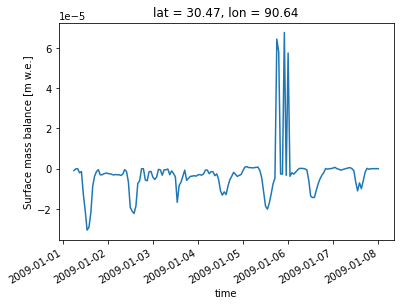

In [141]:
RESULTS.surfMB.plot();

As you can see, the use of xarray-datasets for storing the data makes it possible to levarage the built in plotting functionality of xarray and quickly visualize the output.

For a slightly more advanced plot, one can still make use of matplotlib

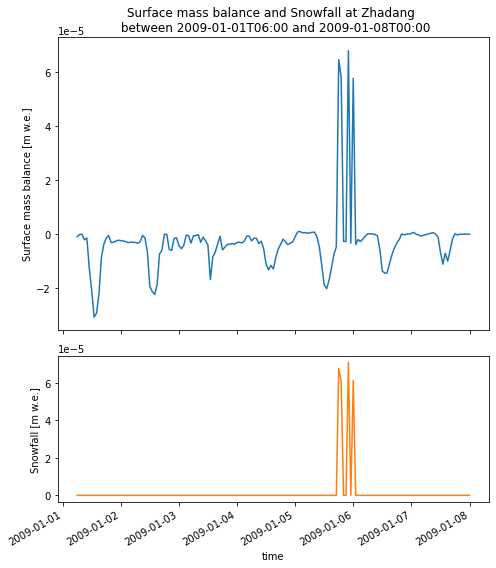

In [142]:
fig, (ax1, ax2) = plt.subplots(figsize=(7,8), nrows=2, sharex=True,
                               gridspec_kw = {'height_ratios':[2,1]})
RESULTS.surfMB.plot(ax=ax1)
RESULTS.SNOWFALL.plot(ax=ax2, color='C1')
# Easier to make use of xarray plotting capabilites and then remove unwanted lables.
ax1.set_xlabel('')
ax2.set_title('')
# Get the time span of our dataset to use for title
time_span = RESULTS.time[0].values, RESULTS.time[-1].values
time_span = np.datetime_as_string(time_span, unit='m')
# Set the title of the plot.
ax1.set_title(f'Surface mass balance and Snowfall at Zhadang \n between {time_span[0]} and' +\
              f' {time_span[1]}')
# Fixes the spacing between parts of the plots.
fig.tight_layout()

As we can see in the figures above, the positive surface mass balances during the 6th or January can be explained, as one might expect, by snowfall.